<a href="https://colab.research.google.com/github/Yoon2596/kita_2404/blob/main/m5_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/%EA%B3%BC%EC%A0%9C/%EA%B3%BC%EC%A0%9C_0725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task1_0725. 타이타닉 생존자 예측 데이터 세트 train.csv에 대하여 다음 사항을 수행하세요.
- 일괄 전처리 사용자 함수 transform_features(df) 작성
- 분류 모델 학습 및 평가 사용자 함수 작성
- dt, lr, rf 모델링 및 평가(정확도)

- GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
  - Decision Tree, Random Forest, Logistic Regression 모델별 수행
  - 선택한 모델에 적합한 parameter greed 적용
  - cv=5 적용

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/KDT_240424/m5_머신러닝/dataset/train.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 한번에
df['Age'].fillna(df['Age'].mean(), inplace=True)
# 안쓰는 컬럼 미리 제거
df.drop(columns = ['PassengerId', 'Cabin', 'Ticket'], inplace=True)
## 앞에 수식어로 이름의 성별 분리
df['Name'] = df['Name'].apply(lambda x: 0 if 'Mrs' in x or 'Miss' in x else 1)

# Convert the 'Gender' column to integer type
df['Name'] = df['Name'].astype(int)
# sibsp와 parch 합쳐서 가족 규모 변수 생성
df['family_size'] = df['SibSp'] + df['Parch'] + 1   # 자기 자신 포함
df.drop(columns=['SibSp', 'Parch'], inplace=True)

# fare를 3개 범주로 변환
fare_bins = [0, 10, 75, 600]
fare_labels = ['Low', 'Medium', 'High']
df['fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels=fare_labels)
df.drop(columns=['Fare'], inplace=True)

# age_group을 6개 범주로 확대
bins = [0, 5, 12, 18, 35, 60, 100]
labels = ['infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins = bins, labels=labels)
df.drop(columns=['Age'], inplace=True)

# 범주형 변수 인코딩
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

# df_n = df['Name']
# df_s = df['Sex']

# # name과 sex 사이의 파라미터가 다른지 확인
# is_same = []

# for idx in range(len(df_n)):
#     if df_n.iloc[idx] != df_s.iloc[idx]:
#         print(idx, df_n.iloc[idx], df_s.iloc[idx])

# # 확인된 이름 성별 데이터 맞춤
# id = [369, 443, 641, 759, 796]

# for i in id:
#     df.loc[i, 'Name'] = 0

df['Embarked'] = df['Embarked'].fillna('S')
df['fare_group'] = df['fare_group'].fillna('Medium')

# 5. One hot encoding
categorical_columns = ['Embarked', 'fare_group', 'age_group']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

# categorical_columns = ['Embarked', 'fare_group', 'age_group']
# dics = {}
# for col in categorical_columns:

#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Survived               891 non-null    int64
 1   Pclass                 891 non-null    int64
 2   Name                   891 non-null    int64
 3   Sex                    891 non-null    int64
 4   family_size            891 non-null    int64
 5   Embarked_C             891 non-null    bool 
 6   Embarked_Q             891 non-null    bool 
 7   Embarked_S             891 non-null    bool 
 8   fare_group_Low         891 non-null    bool 
 9   fare_group_Medium      891 non-null    bool 
 10  fare_group_High        891 non-null    bool 
 11  age_group_infant       891 non-null    bool 
 12  age_group_Child        891 non-null    bool 
 13  age_group_Teenager     891 non-null    bool 
 14  age_group_Young Adult  891 non-null    bool 
 15  age_group_Adult        891 non-null    b

In [ ]:
## 앞에 수식어로 이름의 성별 분리
df['Name'] = df['Name'].apply(lambda x: 0 if 'Mrs' in x or 'Miss' in x else 1)

# Convert the 'Gender' column to integer type
df['Name'] = df['Name'].astype(int)

df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)

df.drop(columns = ['PassengerId', 'Cabin', 'Ticket'], inplace=True) #'Age', 'Embarked'

encoding_columns = ['Name', 'Sex', 'Embarked']
dics = {}
for col in encoding_columns:

    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# sibsp와 parch 합쳐서 가족 규모 변수 생성
df['family_size'] = df['SibSp'] + df['Parch'] + 1   # 자기 자신 포함
df.drop(columns=['SibSp', 'Parch'], inplace=True)

# fare를 3개 범주로 변환
fare_bins = [0, 22, 45, 150]
fare_labels = ['Low', 'Medium', 'High']
df['fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels=fare_labels)
df.drop(columns=['Fare'], inplace=True)

bins = [0, 5, 12, 18, 35, 60, 100]
labels = ['infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins = bins, labels=labels)
df.drop(columns=['Age'], inplace=True)

categorical_columns = ['fare_group', 'age_group']
dics = {}
for col in categorical_columns:

    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Survived     891 non-null    int64
 1   Pclass       891 non-null    int64
 2   Name         891 non-null    int64
 3   Sex          891 non-null    int64
 4   Embarked     891 non-null    int64
 5   family_size  891 non-null    int64
 6   fare_group   891 non-null    int64
 7   age_group    891 non-null    int64
dtypes: int64(8)
memory usage: 55.8 KB


In [ ]:
# 결측치 확인
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Age 쪽은 없는 곳 평균으로 채움
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [ ]:
# 결측치 확인
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# 안쓰는 컬럼 미리 제거
df.drop(columns = ['PassengerId', 'Cabin'], inplace=True)

In [ ]:
## 앞에 수식어로 이름의 성별 분리
df['Name'] = df['Name'].apply(lambda x: 0 if 'Mrs' in x or 'Miss' in x else 1)

# Convert the 'Gender' column to integer type
df['Name'] = df['Name'].astype(int)

print(df)

     Survived  Pclass  Name     Sex        Age  SibSp  Parch  \
0           0       3     1    male  22.000000      1      0   
1           1       1     0  female  38.000000      1      0   
2           1       3     0  female  26.000000      0      0   
3           1       1     0  female  35.000000      1      0   
4           0       3     1    male  35.000000      0      0   
..        ...     ...   ...     ...        ...    ...    ...   
886         0       2     1    male  27.000000      0      0   
887         1       1     0  female  19.000000      0      0   
888         0       3     0  female  29.699118      1      2   
889         1       1     1    male  26.000000      0      0   
890         0       3     1    male  32.000000      0      0   

               Ticket     Fare Embarked  
0           A/5 21171   7.2500        S  
1            PC 17599  71.2833        C  
2    STON/O2. 3101282   7.9250        S  
3              113803  53.1000        S  
4              373450

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,0,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,0,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,0,female,35.0,1,0,113803,53.1000,S
4,0,3,1,male,35.0,0,0,373450,8.0500,S


In [ ]:
print(df['Fare'].min())
print(df['Fare'].max())
print(df['Fare'].mean())

0.0
512.3292
32.204207968574636


In [ ]:
df['Fare'].value_counts().head(30)

Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
10.5000    24
7.9250     18
7.7750     16
7.2292     15
0.0000     15
26.5500    15
7.8542     13
8.6625     13
7.2500     13
7.2250     12
9.5000      9
16.1000     9
24.1500     8
15.5000     8
14.4542     7
69.5500     7
52.0000     7
7.0500      7
56.4958     7
14.5000     7
31.2750     7
39.6875     6
7.7958      6
27.9000     6
30.0000     6
Name: count, dtype: int64

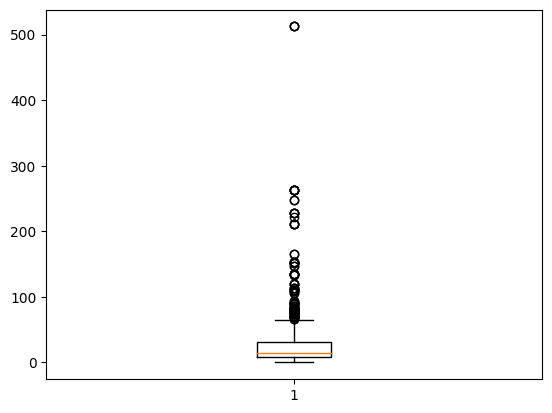

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(df['Fare'])
plt.show()

In [ ]:
# sibsp와 parch 합쳐서 가족 규모 변수 생성
df['family_size'] = df['SibSp'] + df['Parch'] + 1   # 자기 자신 포함
df.drop(columns=['SibSp', 'Parch'], inplace=True)

# fare를 3개 범주로 변환
fare_bins = [0, 10, 75, 600]
fare_labels = ['Low', 'Medium', 'High']
df['fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels=fare_labels)
df.drop(columns=['Fare'], inplace=True)

# age_group을 6개 범주로 확대
bins = [0, 5, 12, 18, 35, 60, 100]
labels = ['infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins = bins, labels=labels)
df.drop(columns=['Age'], inplace=True)

# 범주형 변수 인코딩
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

df.head()

,Survived,Pclass,Name,Sex,Ticket,Embarked,family_size,fare_group,age_group
0,0,3,1,1,A/5 21171,S,2,Low,Young Adult
1,1,1,0,0,PC 17599,C,2,Medium,Adult
2,1,3,0,0,STON/O2. 3101282,S,1,Low,Young Adult
3,1,1,0,0,113803,S,2,Medium,Young Adult
4,0,3,1,1,373450,S,1,Low,Young Adult


In [ ]:
df_n = df['Name']
df_s = df['Sex']

# name과 sex 사이의 파라미터가 다른지 확인
is_same = []

for idx in range(len(df_n)):
    if df_n.iloc[idx] != df_s.iloc[idx]:
        print(idx, df_n.iloc[idx], df_s.iloc[idx])
        # print(is_same.append(idx))
#5정도

369 1 0
443 1 0
641 1 0
759 1 0
796 1 0


In [ ]:
print(df.iloc[369])
print(df.iloc[759])

Survived                 1
Pclass                   1
Name                     1
Sex                      0
Ticket            PC 17477
Embarked                 C
family_size              1
fare_group          Medium
age_group      Young Adult
Name: 369, dtype: object
Survived                 1
Pclass                   1
Name                     1
Sex                      0
Ticket              110152
Embarked                 S
family_size              1
fare_group            High
age_group      Young Adult
Name: 759, dtype: object


In [ ]:
# 확인된 이름 성별 데이터 맞춤
id = [369, 443, 641, 759, 796]

for i in id:
    df.loc[i, 'Name'] = 0

In [ ]:
print(df['Embarked'].unique())
df['Embarked'].value_counts()

['S' 'C' 'Q' nan]


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [ ]:
df['Embarked'] = df['Embarked'].fillna('S')
print(df['Embarked'].unique())

['S' 'C' 'Q']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Name         891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Ticket       891 non-null    object  
 5   Embarked     891 non-null    object  
 6   family_size  891 non-null    int64   
 7   fare_group   876 non-null    category
 8   age_group    891 non-null    category
dtypes: category(2), int64(5), object(2)
memory usage: 50.9+ KB


In [ ]:
# 결측치 확인
print(df.isnull().sum())

Survived        0
Pclass          0
Name            0
Sex             0
Ticket          0
Embarked        0
family_size     0
fare_group     15
age_group       0
dtype: int64


In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Ticket,Embarked,family_size,fare_group,age_group
0,0,3,1,1,A/5 21171,S,2,Low,Young Adult
1,1,1,0,0,PC 17599,C,2,Medium,Adult
2,1,3,0,0,STON/O2. 3101282,S,1,Low,Young Adult
3,1,1,0,0,113803,S,2,Medium,Young Adult
4,0,3,1,1,373450,S,1,Low,Young Adult


In [ ]:
print(df['fare_group'].unique())
print(df['fare_group'].value_counts())
df['fare_group'] = df['fare_group'].fillna('Medium')

['Low', 'Medium', 'High', NaN]
Categories (3, object): ['Low' < 'Medium' < 'High']
fare_group
Medium    458
Low       321
High       97
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Name         891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Ticket       891 non-null    object  
 5   Embarked     891 non-null    object  
 6   family_size  891 non-null    int64   
 7   fare_group   891 non-null    category
 8   age_group    891 non-null    category
dtypes: category(2), int64(5), object(2)
memory usage: 50.9+ KB


In [ ]:
df.drop(columns=['Ticket'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Name         891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Embarked     891 non-null    object  
 5   family_size  891 non-null    int64   
 6   fare_group   891 non-null    category
 7   age_group    891 non-null    category
dtypes: category(2), int64(5), object(1)
memory usage: 44.0+ KB


In [ ]:
# 5. One hot encoding
categorical_columns = ['Embarked', 'fare_group', 'age_group']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Survived               891 non-null    int64
 1   Pclass                 891 non-null    int64
 2   Name                   891 non-null    int64
 3   Sex                    891 non-null    int64
 4   family_size            891 non-null    int64
 5   Embarked_C             891 non-null    bool 
 6   Embarked_Q             891 non-null    bool 
 7   Embarked_S             891 non-null    bool 
 8   fare_group_Low         891 non-null    bool 
 9   fare_group_Medium      891 non-null    bool 
 10  fare_group_High        891 non-null    bool 
 11  age_group_infant       891 non-null    bool 
 12  age_group_Child        891 non-null    bool 
 13  age_group_Teenager     891 non-null    bool 
 14  age_group_Young Adult  891 non-null    bool 
 15  age_group_Adult        891 non-null    b

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

(712, 16) (179, 16) (712,) (179,)
Accuracy: 0.8212290502793296
Precision: 0.85
Recall: 0.6891891891891891
F1 Score: 0.7611940298507462
ROC AUC: 0.8285070785070786
[[96  9]
 [23 51]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



Model: Decision Tree
Accuracy: 0.7910447761194029
Precision: 0.8235294117647058
Recall: 0.6306306306306306
F1 Score: 0.7142857142857143
ROC AUC: 0.7991622195443853
[[142  15]
 [ 41  70]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       157
           1       0.82      0.63      0.71       111

    accuracy                           0.79       268
   macro avg       0.80      0.77      0.77       268
weighted avg       0.80      0.79      0.79       268



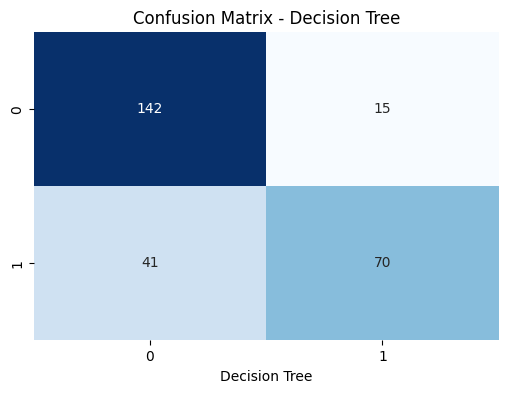


Model: Random Forest
Accuracy: 0.7835820895522388
Precision: 0.797752808988764
Recall: 0.6396396396396397
F1 Score: 0.71
ROC AUC: 0.8331038044413841
[[139  18]
 [ 40  71]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       157
           1       0.80      0.64      0.71       111

    accuracy                           0.78       268
   macro avg       0.79      0.76      0.77       268
weighted avg       0.79      0.78      0.78       268



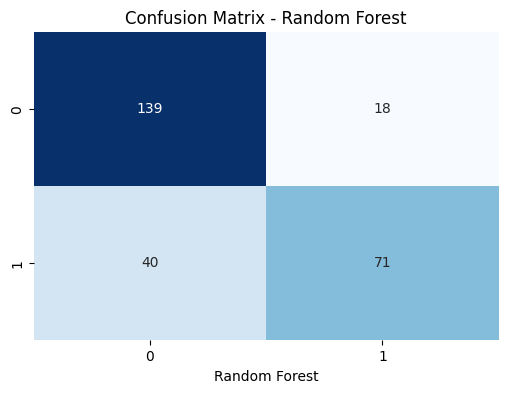


Model: Logistic Regression
Accuracy: 0.8171641791044776
Precision: 0.81
Recall: 0.7297297297297297
F1 Score: 0.7677725118483413
ROC AUC: 0.8702874849371665
[[138  19]
 [ 30  81]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       157
           1       0.81      0.73      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



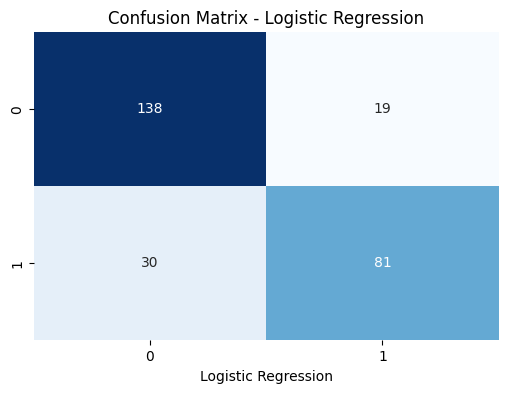

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# 모델 평가
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 성능 평가
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel(model_name)
    plt.show()
    print()

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter = 100, random_state=42)
}

for model_name, model in models.items():
    print(f"Model: {model_name}")
    evaluate_model(model, X_train, y_train, X_test, y_test)



Fitting 5 folds for each of 7680 candidates, totalling 38400 fits
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 10}
Accuracy: 0.8022
Confusion_matrix: [[147  10]
 [ 43  68]]
Classification_report:               precision    recall  f1-score   support

           0       0.77      0.94      0.85       157
           1       0.87      0.61      0.72       111

    accuracy                           0.80       268
   macro avg       0.82      0.77      0.78       268
weighted avg       0.81      0.80      0.79       268



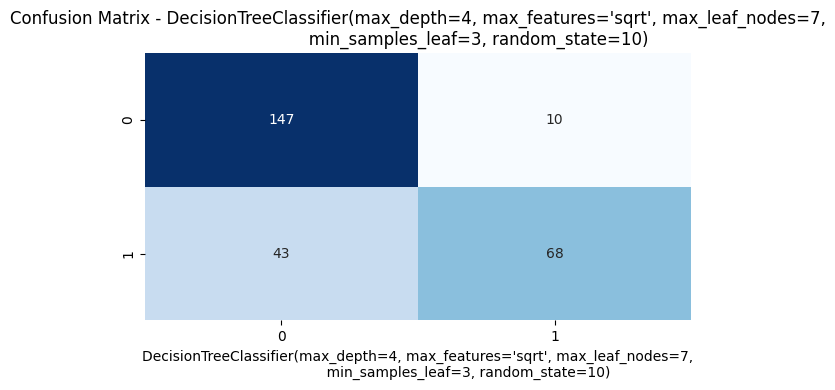

In [ ]:
# DecisionTree

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# 모델 평가
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # 예측
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion_matrix: {conf_matrix}")
    print(f"Classification_report: {class_report}")

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel(model)
    plt.tight_layout()
    plt.show()
    print()

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

hyperparameters = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5, 8],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [1, 2, 5, 7, 10],
    'random_state': [0, 10, 42, 100]
}

# 모델 생성
dt = DecisionTreeClassifier()

# GridSearchCV 설정 및 적용
grid_search = GridSearchCV(estimator=dt,
                           param_grid=hyperparameters,
                           n_jobs=-1,
                           verbose=2,
                           cv=5)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_train, y_train, X_test, y_test)




Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8060
Confusion_matrix: [[143  14]
 [ 38  73]]
Classification_report:               precision    recall  f1-score   support

           0       0.79      0.91      0.85       157
           1       0.84      0.66      0.74       111

    accuracy                           0.81       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.81      0.80       268



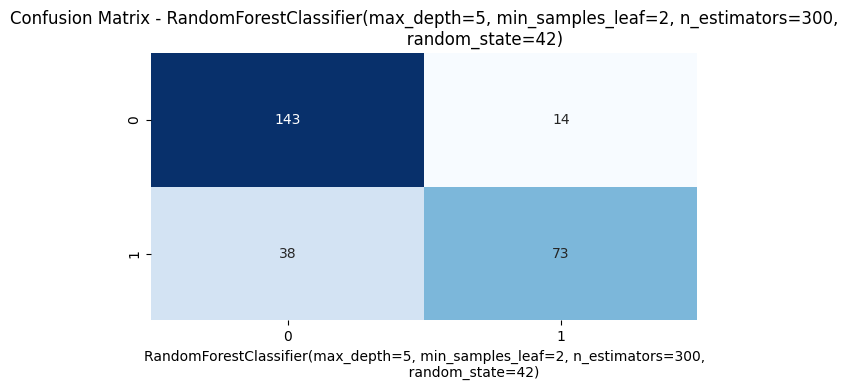

In [ ]:
# RandomForest

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# 모델 평가
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # 예측
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion_matrix: {conf_matrix}")
    print(f"Classification_report: {class_report}")

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel(model)
    plt.tight_layout()
    plt.show()
    print()

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

hyperparameters = {
    'n_estimators' :[50, 100, 300, 500],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 모델 생성
dt = RandomForestClassifier(random_state=42)

# GridSearchCV 설정 및 적용
grid_search = GridSearchCV(estimator=dt,
                           param_grid=hyperparameters,
                           n_jobs=-1,
                           verbose=2,
                           cv=5)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_train, y_train, X_test, y_test)




Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Best parameters: {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8209
Confusion_matrix: [[139  18]
 [ 30  81]]
Classification_report:               precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.73      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



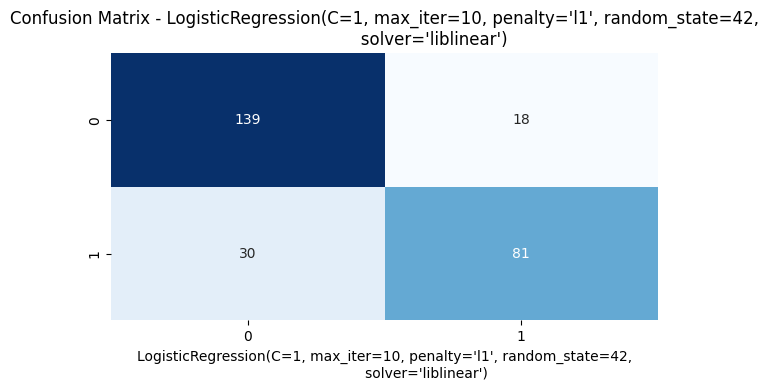

In [ ]:
# LogisticRegression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 모델 평가
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # 예측
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion_matrix: {conf_matrix}")
    print(f"Classification_report: {class_report}")

    # 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel(model)
    plt.tight_layout()
    plt.show()
    print()

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

hyperparameters = {
    'max_iter' :[10, 15, 30, 50, 70, 100, 200, 300],
    'C': [0.1, 1, 2, 3, 5, 7, 10],
    'penalty': ['l2', 'l1'],
    'solver':['lbfgs', 'liblinear']
}

# 모델 생성
lr = LogisticRegression( random_state=42)

# GridSearchCV 설정 및 적용
grid_search = GridSearchCV(estimator=lr,
                           param_grid=hyperparameters,
                           n_jobs=-1,
                           verbose=2,
                           cv=5)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_train, y_train, X_test, y_test)




# 강사님 버전


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 사용자 정의 함수
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    confusion = confusion_matrix(y_test, y_pred)

    print(f'오차 행렬:\n{confusion}')
    print(f'정확도: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1 스코어: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('')

In [ ]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출.

y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11, stratify=y_titanic_df)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=10)
rf_clf = RandomForestClassifier(random_state=10)
lr_clf = LogisticRegression(max_iter=2000, random_state=10)
print('dt_clf 학습')
print('='*12)
train_and_evaluate(dt_clf, X_train, X_test, y_train, y_test)
print('rf_clf 학습')
print('='*12)
train_and_evaluate(rf_clf, X_train, X_test, y_train, y_test)
print('lr_clf 학습')
print('='*12)
train_and_evaluate(lr_clf, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10,12],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8,10]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

train_and_evaluate(best_dclf, X_train, X_test, y_train, y_test)


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10,100,200], 'max_depth':[2,3,5,10,12],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8,10]}

grid_rfclf = GridSearchCV(rf_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_rfclf.fit(X_train , y_train)


print('GridSearchCV 최적 하이퍼 파라미터 :',grid_rfclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_rfclf.best_score_))
best_rfclf = grid_rfclf.best_estimator_

train_and_evaluate(best_rfclf, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 50, 100]
}
grid_lrclf = GridSearchCV(lr_clf , param_grid=param_grid , cv=5, verbose=0)
grid_lrclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_lrclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_lrclf.best_score_))
best_lrclf = grid_lrclf.best_estimator_

train_and_evaluate(best_lrclf, X_train, X_test, y_train, y_test)